In [1]:
import pandas as pd 
import numpy as np
import os
from sqlalchemy import create_engine

In [2]:
engine=create_engine('sqlite:///project3.db')
path=r"C:\Users\admin\OneDrive\MANSOOR ALI\project_3"

In [3]:
useful_columns = {
    'orders': ['order_id', 'created_at', 'website_session_id', 'user_id',
               'primary_product_id', 'price_usd', 'cogs_usd'],
    
    'order_items': ['order_item_id', 'order_id', 'product_id', 
                    'is_primary_item', 'price_usd', 'cogs_usd'],
    
    'order_item_refunds': ['order_item_id', 'order_id', 
                           'refund_amount_usd', 'created_at'],
    
    'products': ['product_id', 'product_name', 'created_at'],
    
    'website_sessions': ['website_session_id', 'user_id', 'created_at',
                         'is_repeat_session', 'utm_source', 'utm_campaign', 'device_type'],
    
    'website_pageviews': ['website_pageview_id', 'website_session_id', 'created_at', 'pageview_url']
}


In [4]:
for file in os.listdir(path):
    if file.endswith(".csv"):
        table_name=file.replace('.csv','')
        df=pd.read_csv(os.path.join(path,file))
        if table_name in useful_columns:
            df=df[[col for col in df.columns if col in useful_columns[table_name]]]
df.to_sql(table_name,con=engine,index=False,if_exists='replace')
print(f"loaded useful columns for: {"table_name"}")
print(f"columns:{list(df.columns)}")
print("-"*60)

loaded useful columns for: table_name
columns:['website_session_id', 'created_at', 'user_id', 'is_repeat_session', 'utm_source', 'utm_campaign', 'device_type']
------------------------------------------------------------


In [5]:
pd.read_sql_query("SELECT * FROM orders LIMIT 5", engine)


,created_at,website_session_id,user_id,primary_product_id,items_purchased,price_usd,cogs_usd
0,06-12-2014 15:24,386127,294290,4,1,29.99,9.49
1,07-12-2014 04:05,386287,326189,4,1,29.99,9.49
2,07-12-2014 08:10,386336,326228,4,1,29.99,9.49
3,07-12-2014 12:29,386428,326304,4,1,29.99,9.49
4,07-12-2014 17:18,386567,326415,4,1,29.99,9.49


In [23]:
query="""select count(utm_campaign)
from website_sessions"""
result= pd.read_sql(query,engine)
print(result)

   count(utm_campaign)
0               389543


In [5]:
from sqlalchemy import text
with engine.connect() as conn:
    result = conn.execute(text("SELECT name FROM sqlite_master WHERE type='table';"))
    print([row[0] for row in result])



['orders', 'order_items', 'order_item_refunds', 'products', 'website_pageviews', 'combined_analysis_data', 'website_sessions']


In [6]:
print("Columns:", list(df.columns))
print("-" * 60)


Columns: ['website_session_id', 'created_at', 'user_id', 'is_repeat_session', 'utm_source', 'utm_campaign', 'device_type']
------------------------------------------------------------


In [7]:
from sqlalchemy import inspect

inspector = inspect(engine)
tables = inspector.get_table_names()
print("📋 Tables in engine:", tables)

for table in tables:
    columns = [col['name'] for col in inspector.get_columns(table)]
    print(f"\n🔹 {table} columns:")
    print(columns)


📋 Tables in engine: ['combined_analysis_data', 'order_item_refunds', 'order_items', 'orders', 'products', 'website_pageviews', 'website_sessions']

🔹 combined_analysis_data columns:
['order_created_at', 'user_id', 'website_session_id', 'primary_product_id', 'items_purchased', 'order_price_usd', 'order_cogs_usd', 'order_item_id', 'product_id', 'is_primary_item', 'item_price_usd', 'item_cogs_usd', 'order_item_refund_id', 'refund_amount_usd', 'product_name', 'is_repeat_session', 'utm_source', 'utm_campaign', 'device_type', 'pageview_url']

🔹 order_item_refunds columns:
['order_item_refund_id', 'created_at', 'order_item_id', 'order_id', 'refund_amount_usd']

🔹 order_items columns:
['order_item_id', 'created_at', 'order_id', 'product_id', 'is_primary_item', 'price_usd', 'cogs_usd']

🔹 orders columns:
['created_at', 'website_session_id', 'user_id', 'primary_product_id', 'items_purchased', 'price_usd', 'cogs_usd']

🔹 products columns:
['product_id', 'created_at', 'product_name']

🔹 website_pa

In [8]:
query = """
SELECT
    o.created_at AS order_created_at,
    o.user_id,
    o.website_session_id,
    o.primary_product_id,
    o.items_purchased,
    o.price_usd AS order_price_usd,
    o.cogs_usd AS order_cogs_usd,

    oi.order_item_id,
    oi.product_id,
    oi.is_primary_item,
    oi.price_usd AS item_price_usd,
    oi.cogs_usd AS item_cogs_usd,

    r.order_item_refund_id,
    r.refund_amount_usd,

    p.product_name,

    ws.is_repeat_session,
    ws.utm_source,
    ws.utm_campaign,
    ws.device_type,

    wp.pageview_url

FROM order_items oi
LEFT JOIN orders o
    ON oi.order_id = o.rowid   -- since orders has no order_id column
LEFT JOIN order_item_refunds r
    ON oi.order_item_id = r.order_item_id
LEFT JOIN products p
    ON oi.product_id = p.product_id
LEFT JOIN website_sessions ws
    ON o.website_session_id = ws.website_session_id
LEFT JOIN website_pageviews wp
    ON ws.website_session_id = wp.website_session_id;
"""
combined_df = pd.read_sql_query(query, engine)
combined_df.to_sql('combined_analysis_data', con=engine, index=False, if_exists='replace')

print("✅ Combined table created successfully!")



✅ Combined table created successfully!


In [9]:
combined_df.columns

Index(['order_created_at', 'user_id', 'website_session_id',
       'primary_product_id', 'items_purchased', 'order_price_usd',
       'order_cogs_usd', 'order_item_id', 'product_id', 'is_primary_item',
       'item_price_usd', 'item_cogs_usd', 'order_item_refund_id',
       'refund_amount_usd', 'product_name', 'is_repeat_session', 'utm_source',
       'utm_campaign', 'device_type', 'pageview_url'],
      dtype='object')

In [10]:
combined_df.isnull().sum()

order_created_at             0
user_id                      0
website_session_id           0
primary_product_id           0
items_purchased              0
order_price_usd              0
order_cogs_usd               0
order_item_id                0
product_id                   0
is_primary_item              0
item_price_usd               0
item_cogs_usd                0
order_item_refund_id    268058
refund_amount_usd       268058
product_name                 0
is_repeat_session            0
utm_source               53830
utm_campaign             53830
device_type                  0
pageview_url                 0
dtype: int64

In [11]:
query = """
SELECT order_item_refund_id, refund_amount_usd
FROM combined_analysis_data
"""
result = pd.read_sql_query(query, engine)
print(result.head())


   order_item_refund_id  refund_amount_usd
0                   NaN                NaN
1                   NaN                NaN
2                   NaN                NaN
3                   NaN                NaN
4                   NaN                NaN


In [12]:
query = """
SELECT count(order_item_refund_id)
FROM combined_analysis_data
"""
result = pd.read_sql_query(query, engine)
print(result)

   count(order_item_refund_id)
0                        12117


In [13]:

query = """
SELECT count(order_item_refund_id)
FROM combined_analysis_data
where order_item_refund_id is null
"""
result = pd.read_sql_query(query, engine)
print(result)

   count(order_item_refund_id)
0                            0


In [29]:
combined_df = combined_df.fillna({
    "refund_amount_usd": 0,
    "order_item_refund_id": 0,
    "utm_source": "unknown",
    "utm_campaign": "none",
    "pageview_url": "none"
})


In [30]:
combined_df.isnull().sum()

order_created_at        0
user_id                 0
website_session_id      0
primary_product_id      0
items_purchased         0
order_price_usd         0
order_cogs_usd          0
order_item_id           0
product_id              0
is_primary_item         0
item_price_usd          0
item_cogs_usd           0
order_item_refund_id    0
refund_amount_usd       0
product_name            0
is_repeat_session       0
utm_source              0
utm_campaign            0
device_type             0
pageview_url            0
dtype: int64

In [31]:
combined_df.isna().sum()

order_created_at        0
user_id                 0
website_session_id      0
primary_product_id      0
items_purchased         0
order_price_usd         0
order_cogs_usd          0
order_item_id           0
product_id              0
is_primary_item         0
item_price_usd          0
item_cogs_usd           0
order_item_refund_id    0
refund_amount_usd       0
product_name            0
is_repeat_session       0
utm_source              0
utm_campaign            0
device_type             0
pageview_url            0
dtype: int64

In [32]:
combined_df.info

<bound method DataFrame.info of           order_created_at  user_id  website_session_id  primary_product_id  \
0      2014-12-06 15:24:00   294290              386127                   4   
1      2014-12-06 15:24:00   294290              386127                   4   
2      2014-12-06 15:24:00   294290              386127                   4   
3      2014-12-06 15:24:00   294290              386127                   4   
4      2014-12-06 15:24:00   294290              386127                   4   
...                    ...      ...                 ...                 ...   
280170 2015-03-18 18:15:00   394016              472485                   1   
280171 2015-03-18 18:15:00   394016              472485                   1   
280172 2015-03-18 18:15:00   394016              472485                   1   
280173 2015-03-18 18:15:00   394016              472485                   1   
280174 2015-03-18 18:15:00   394016              472485                   1   

        items_purch

In [18]:
combined_df.dtypes

order_created_at         object
user_id                   int64
website_session_id        int64
primary_product_id        int64
items_purchased           int64
order_price_usd         float64
order_cogs_usd          float64
order_item_id             int64
product_id                int64
is_primary_item           int64
item_price_usd          float64
item_cogs_usd           float64
order_item_refund_id    float64
refund_amount_usd       float64
product_name             object
is_repeat_session         int64
utm_source               object
utm_campaign             object
device_type              object
pageview_url             object
dtype: object

In [19]:
combined_df.head()

,order_created_at,user_id,website_session_id,primary_product_id,items_purchased,order_price_usd,order_cogs_usd,order_item_id,product_id,is_primary_item,item_price_usd,item_cogs_usd,order_item_refund_id,refund_amount_usd,product_name,is_repeat_session,utm_source,utm_campaign,device_type,pageview_url
0,06-12-2014 15:24,294290,386127,4,1,29.99,9.49,1,1,1,49.99,19.49,0.0,0.0,The Original Mr. Fuzzy,1,unknown,none,desktop,/billing-2
1,06-12-2014 15:24,294290,386127,4,1,29.99,9.49,1,1,1,49.99,19.49,0.0,0.0,The Original Mr. Fuzzy,1,unknown,none,desktop,/cart
2,06-12-2014 15:24,294290,386127,4,1,29.99,9.49,1,1,1,49.99,19.49,0.0,0.0,The Original Mr. Fuzzy,1,unknown,none,desktop,/home
3,06-12-2014 15:24,294290,386127,4,1,29.99,9.49,1,1,1,49.99,19.49,0.0,0.0,The Original Mr. Fuzzy,1,unknown,none,desktop,/products
4,06-12-2014 15:24,294290,386127,4,1,29.99,9.49,1,1,1,49.99,19.49,0.0,0.0,The Original Mr. Fuzzy,1,unknown,none,desktop,/shipping


In [33]:
combined_df['order_created_at'] = pd.to_datetime(
    combined_df['order_created_at'],
    format='%d-%m-%Y %H:%M'
)

print(combined_df.dtypes)


order_created_at        datetime64[ns]
user_id                          int64
website_session_id               int64
primary_product_id               int64
items_purchased                  int64
order_price_usd                float64
order_cogs_usd                 float64
order_item_id                    int64
product_id                       int64
is_primary_item                  int64
item_price_usd                 float64
item_cogs_usd                  float64
order_item_refund_id           float64
refund_amount_usd              float64
product_name                    object
is_repeat_session                int64
utm_source                      object
utm_campaign                    object
device_type                     object
pageview_url                    object
dtype: object


In [34]:
combined_df['product_name'].unique()


array(['The Original Mr. Fuzzy', 'The Forever Love Bear',
       'The Birthday Sugar Panda', 'The Hudson River Mini bear'],
      dtype=object)

In [22]:
combined_df['product_name'].nunique()


4

In [23]:
combined_df['device_type'].unique()

array(['desktop', 'mobile'], dtype=object)

In [24]:
combined_df['utm_source'].unique()

array(['unknown', 'gsearch', 'bsearch', 'socialbook'], dtype=object)

In [25]:
combined_df['utm_campaign'].unique()

array(['none', 'brand', 'nonbrand', 'desktop_targeted', 'pilot'],
      dtype=object)

In [26]:
combined_df['pageview_url'].unique()

array(['/billing-2', '/cart', '/home', '/products', '/shipping',
       '/thank-you-for-your-order', '/the-hudson-river-mini-bear',
       '/lander-5', '/lander-3', '/lander-2', '/the-birthday-sugar-panda',
       '/lander-4', '/billing', '/the-original-mr-fuzzy', '/lander-1',
       '/the-forever-love-bear'], dtype=object)

In [35]:
numeric_cols=[
    'order_price_usd',
    'order_cogs_usd',
    'item_price_usd',
    'item_cogs_usd',
    'refund_amount_usd',
    'items_purchased'
]

In [36]:
outliers={}
for col in numeric_cols:
    Q1= combined_df[col].quantile(0.25)
    Q3= combined_df[col].quantile(0.75)
    IQR=Q3-Q1
    
    lower=Q1-1.5*IQR
    upper=Q3+1.5*IQR
    outlier_count=combined_df[(combined_df[col]<lower)| (combined_df[col]>upper)].shape[0]
    outliers[col]=outlier_count

outliers
    

{'order_price_usd': 0,
 'order_cogs_usd': 40166,
 'item_price_usd': 110593,
 'item_cogs_usd': 110593,
 'refund_amount_usd': 12117,
 'items_purchased': 0}

In [25]:
combined_df.describe()

,order_created_at,user_id,website_session_id,primary_product_id,items_purchased,order_price_usd,order_cogs_usd,order_item_id,product_id,is_primary_item,item_price_usd,item_cogs_usd,order_item_refund_id,refund_amount_usd,is_repeat_session
count,280175,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000,280175.000000
mean,2014-05-05 18:34:14.250093568,223806.384235,268194.014016,1.380437,1.257614,60.966512,22.719966,20013.000000,1.770019,0.807320,48.432473,18.047976,37.452742,2.132135,0.192655
min,2012-03-19 10:42:00,13.000000,20.000000,1.000000,1.000000,29.990000,9.490000,1.000000,1.000000,0.000000,29.990000,9.490000,0.000000,0.000000,0.000000
25%,2013-12-09 18:01:00,140235.000000,165162.000000,1.000000,1.000000,49.990000,19.490000,10007.000000,1.000000,1.000000,49.990000,19.490000,0.000000,0.000000,0.000000
50%,2014-07-03 08:13:00,231790.000000,276767.000000,1.000000,1.000000,49.990000,19.490000,20013.000000,1.000000,1.000000,49.990000,19.490000,0.000000,0.000000,0.000000
75%,2014-12-01 07:58:00,314604.000000,379648.000000,2.000000,2.000000,75.980000,23.980000,30019.000000,2.000000,1.000000,49.990000,19.490000,0.000000,0.000000,0.000000
max,2015-03-19 05:38:00,394273.000000,472818.000000,4.000000,2.000000,109.980000,41.980000,40025.000000,4.000000,1.000000,59.990000,22.490000,1731.000000,59.990000,1.000000
std,NaN,105341.630498,128770.597255,0.705296,0.437321,18.103111,6.292192,11554.242878,1.085550,0.394404,8.012284,3.856780,204.524791,10.081207,0.394385


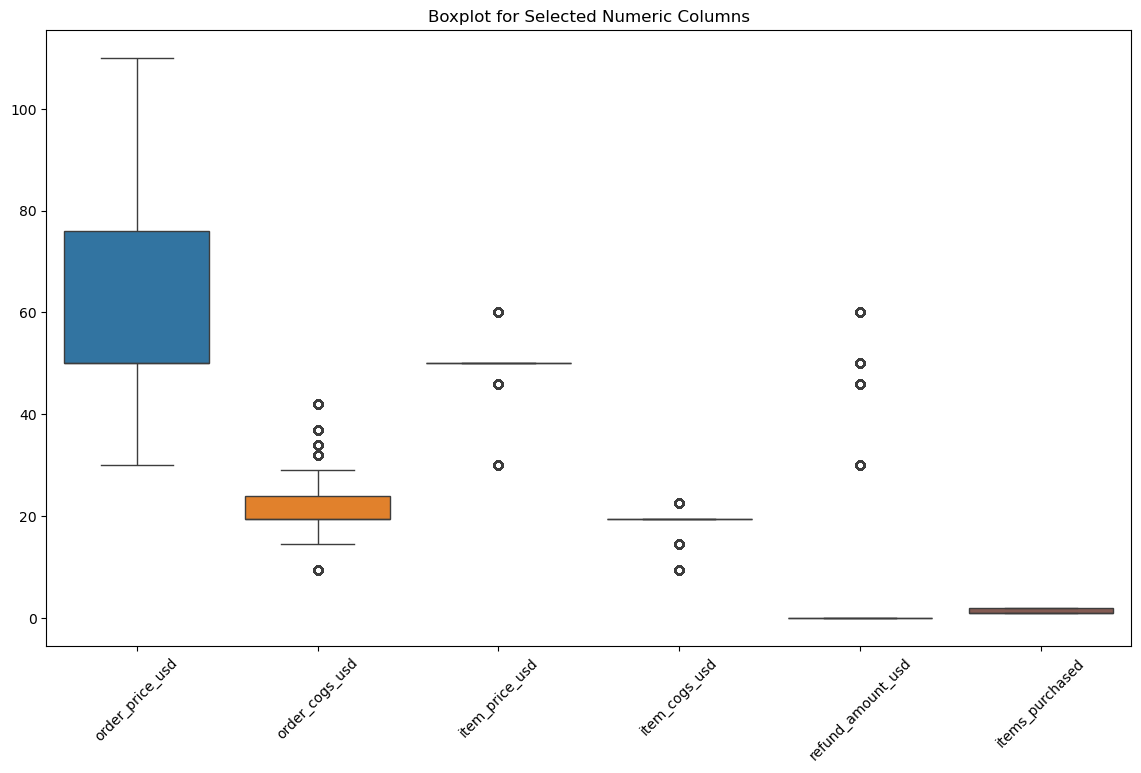

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_cols = [
    'order_price_usd',
    'order_cogs_usd',
    'item_price_usd',
    'item_cogs_usd',
    'refund_amount_usd',
    'items_purchased'
]

plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_df[selected_cols])
plt.title("Boxplot for Selected Numeric Columns")
plt.xticks(rotation=45)
plt.show()


In [75]:
combined_df['refund_amount_usd'].value_counts()

refund_amount_usd
0.00     268058
49.99      8659
45.99      2107
59.99       903
29.99       448
Name: count, dtype: int64

In [76]:
combined_df['item_price_usd'].value_counts()

item_price_usd
49.99    169582
59.99     40572
29.99     35126
45.99     34895
Name: count, dtype: int64

In [82]:
faulty_refund_count = (combined_df['refund_amount_usd'] > combined_df['item_price_usd']).sum()
faulty_refund_count


np.int64(0)

In [84]:
combined_df['item_cogs_usd'].value_counts()

item_cogs_usd
19.49    169582
22.49     40572
9.49      35126
14.49     34895
Name: count, dtype: int64

In [86]:
combined_df['items_purchased'].value_counts()

items_purchased
1    207998
2     72177
Name: count, dtype: int64

In [91]:
combined_df['order_cogs_usd'].value_counts()

order_cogs_usd
19.49    152453
22.49     37534
28.98     29428
33.98     18620
14.49     14273
41.98      8946
31.98      6510
23.98      6321
9.49       3738
36.98      2352
Name: count, dtype: int64

In [92]:
combined_df['order_cogs_usd'].value_counts().sum()

np.int64(280175)

In [36]:
combined_df['order_price_usd'].value_counts()

order_price_usd
49.99     152453
59.99      37534
79.98      29428
95.98      18620
45.99      14273
109.98      8946
89.98       6510
75.98       6321
29.99       3738
105.98      2352
Name: count, dtype: int64

Although some values appear outside the standard IQR range, analysis of value-frequency (value_counts) shows that these are repeated price points and not data-entry errors. Therefore, these outliers are genuine business values and were retained for analysis.

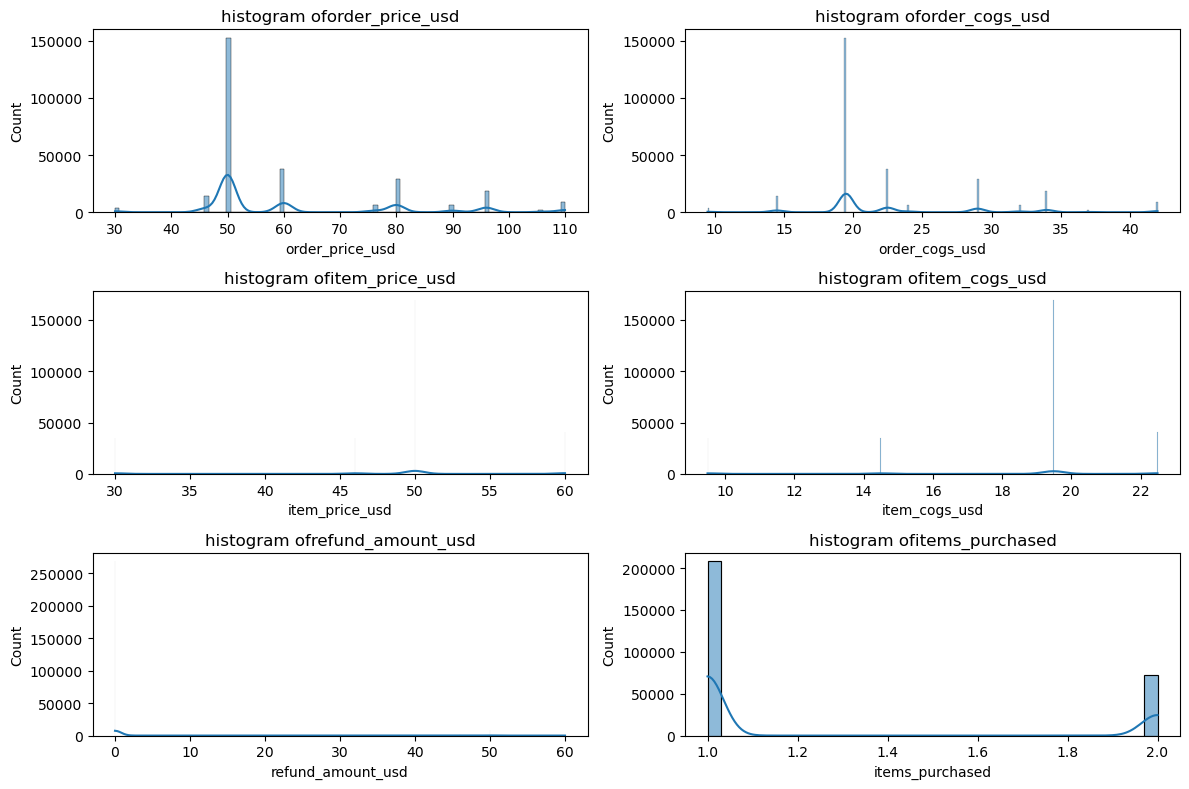

In [39]:
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols,1):
    plt.subplot(3,2,i)
    sns.histplot(combined_df[col],kde=True)
    plt.title(f"histogram of{col}")
plt.tight_layout()
plt.show()

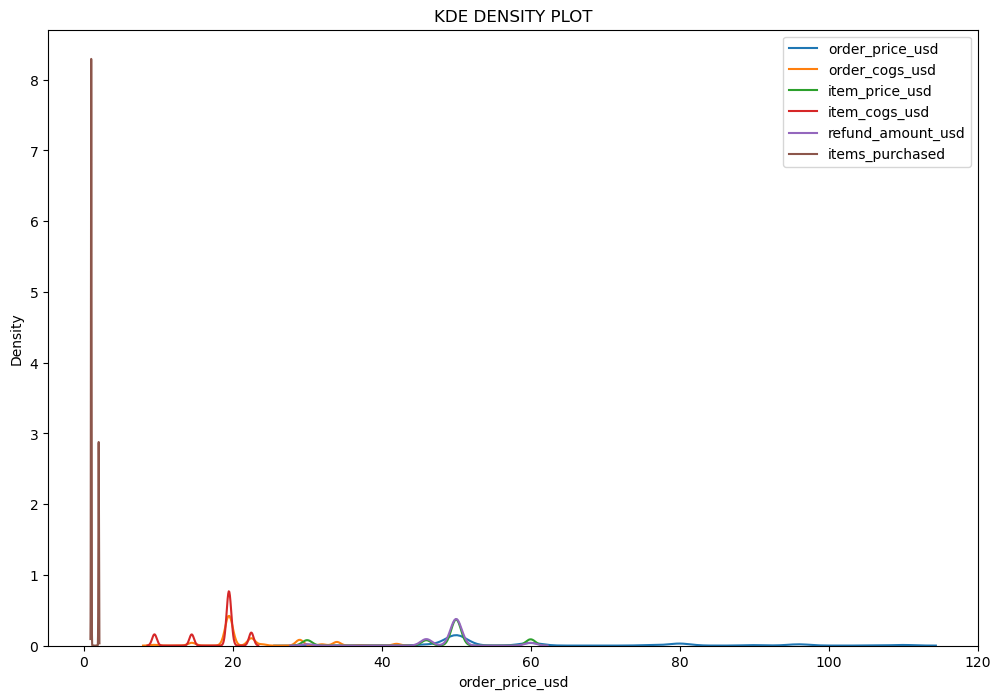

In [20]:
plt.figure(figsize=(12,8))
for col in numeric_cols:
    sns.kdeplot(combined_df[col],label=col)
plt.title("KDE DENSITY PLOT")
plt.legend()
plt.show()

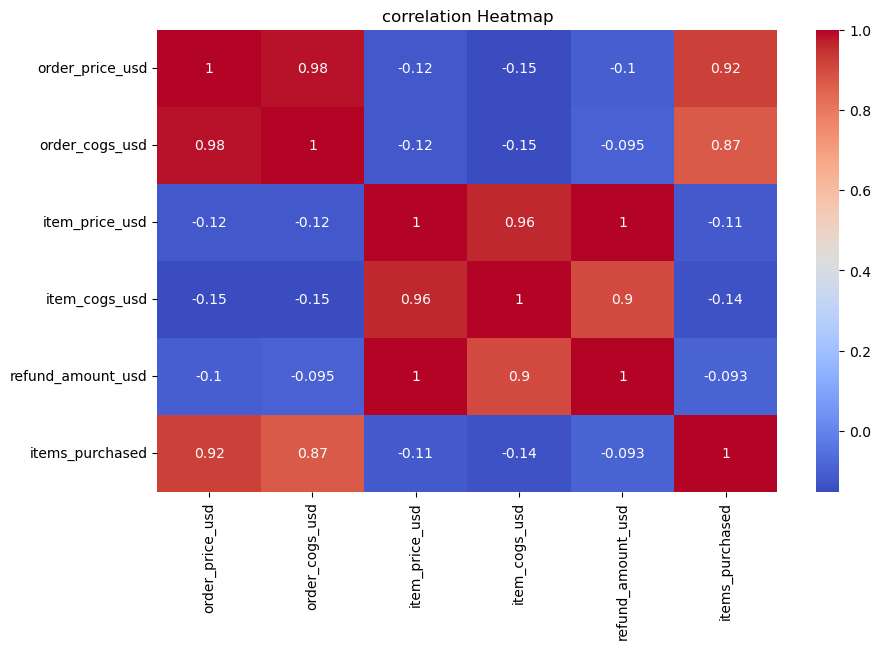

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(combined_df[numeric_cols].corr(),annot=True,cmap="coolwarm")
plt.title("correlation Heatmap")
plt.show()

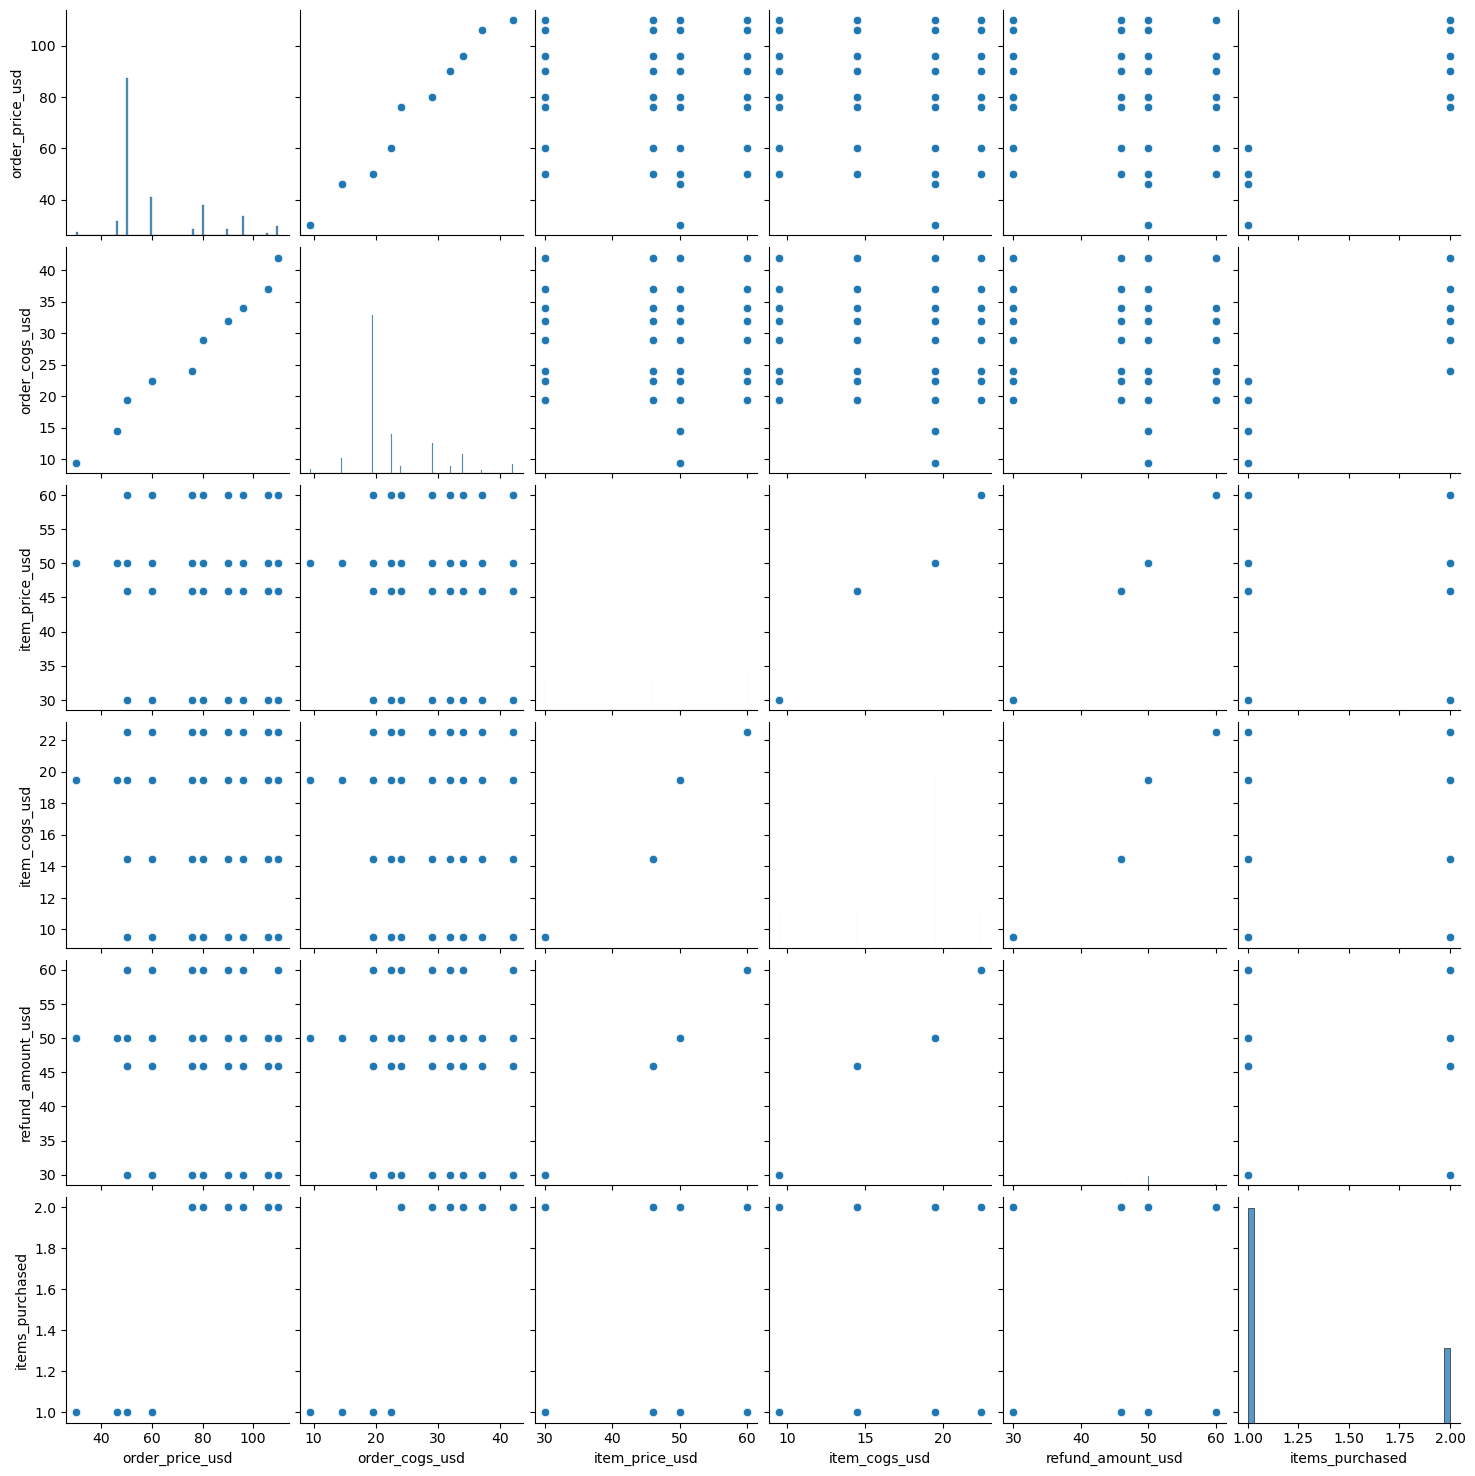

In [22]:
sns.pairplot(combined_df[numeric_cols])
plt.show()

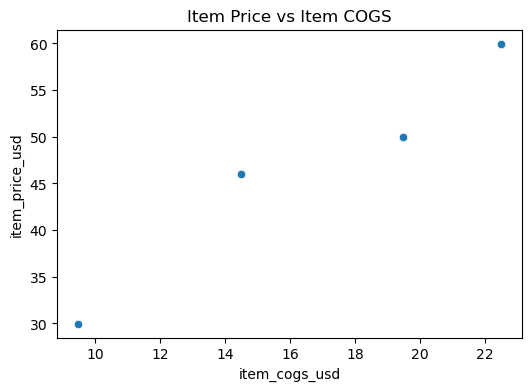

In [23]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=combined_df, x='item_cogs_usd', y='item_price_usd')
plt.title("Item Price vs Item COGS")
plt.show()


In [40]:
combined_df.to_csv("combined_data_02.csv",index=False)

In [41]:
combined_df['refund_amount_usd'].value_counts()

refund_amount_usd
0.00     268058
49.99      8659
45.99      2107
59.99       903
29.99       448
Name: count, dtype: int64